### Accent detection of english language videos using Neural Networks

This notebook is based on the accent detection dataset on kaggle (https://www.kaggle.com/datasets/rtatman/speech-accent-archive/data) and for the notebook to work, you would need to download the dataset and store it in '/kaggle/input/recordings/recordings'

In [136]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

from tqdm import tqdm
tqdm.pandas()

In [137]:
dir = os.getcwd()+'/kaggle/input/recordings/recordings'
audio_list = os.listdir(dir)

Create a dataframe and Get the labels to the dataset

In [404]:
df = pd.DataFrame()
df['speech'] = audio_list
df['labels'] = [re.sub(r'\d+\.mp3$', '', audio) for audio in audio_list]

df.head()

,speech,labels
0,afrikaans1.mp3,afrikaans
1,afrikaans2.mp3,afrikaans
2,afrikaans3.mp3,afrikaans
3,afrikaans4.mp3,afrikaans
4,afrikaans5.mp3,afrikaans


We now make genralized classification that will help us identify the accent of the speaker into 10 categories

In [139]:
english = ['english']

indian = [
    'hindi', 'urdu', 'bengali', 'nepali', 'punjabi', 'gujarati', 'tamil',
    'telugu', 'oriya', 'marathi', 'malayalam', 'konkani',
    'kannada', 'sindhi', 'hindko','mizo'
]

east_asian = [
    'mandarin', 'cantonese', 'japanese','hainanese', 'xiang', 'wu', 'gan', 'hakka',
    'teochew', 'shan', 'taiwanese'
]
se_asian = ['vietnamese','thai', 'filipino', 'tagalog', 'indonesian', 'burmese', 'khmer',
    'malay', 'lao'
]

middle_eastern_central_asian = ['greek','farsi', 'turkish', 'hebrew', 'kurdish', 'pashto', 'tajiki',
    'kazakh', 'uzbek', 'turkmen', 'azerbaijani', 'dari', 'arabic',
    'uyghur', 'tatar', 'armenian', 'georgian']

african = [
    'amharic', 'swahili', 'somali', 'yoruba', 'zulu', 'hausa', 'igbo',
    'afrikaans', 'rwanda', 'shona', 'bambara', 'tigrigna', 'moore',
    'kikongo', 'pulaar', 'susu', 'akan', 'lusoga', 'tswana', 'bamun',
    'sara', 'wolof', 'nuer', 'dinka', 'bari', 'mandinka', 'ibibio',
    'kru', 'garifuna', 'kambaata', 'namibian', 'nandi', 'luo', 'xasonga',
    'gedeo', 'fang', 'ashanti', 'serer', 'kikuyu', 'bafang', 'hadiyya'
]

oceanian = [
    'fijian', 'pohnpeian', 'chamorro', 'carolinian', 'yapese', 'rotuman',
    'bai', 'lamotrekese', 'mortlockese', 'satawalese', 'cebuano'
]

western_european = [
    'french', 'german', 'dutch', 'portuguese', 'spanish', 'italian', 'sicilian', 'catalan'
    'irish', 'faroese', 'frisian', 'vlaams', 'luxembourgeois', 'maltese', 'basque', 'sardinian', 'bavarian'
]

northern_european = [
    'swedish', 'danish', 'norwegian', 'finnish', 'icelandic', 'estonian'
]

eastern_european = [ 'russian', 'polish', 'czech', 'slovak', 'ukrainian', 'belarusan', 'bulgarian',
    'romanian', 'serbian', 'croatian', 'bosnian', 'slovenian', 'macedonian', 'albanian'
]



We create a new column in the dataset to incorporate these classification markers

In [141]:
def get_general_label(x):
    if x in english:
        return 'English'
    if x in indian:
        return 'Indian'
    if x in east_asian:
        return 'East Asian'
    if x in se_asian:
        return 'South East Asian'
    if x in middle_eastern_central_asian:
        return 'Middle Eastern, Central Asian or Southern Europe'
    if x in african:
        return 'African'
    if x in western_european:
        return 'Western European'
    if x in northern_european:
        return 'Northern European'
    if x in eastern_european:
        return 'Eastern European'
    return 'Oceanian or Other'

df['general_label'] = df.labels.progress_apply(get_general_label)

100%|██████████| 2138/2138 [00:00<00:00, 534506.88it/s]


In [142]:
df.head()

,speech,labels,general_label
0,afrikaans1.mp3,afrikaans,African
1,afrikaans2.mp3,afrikaans,African
2,afrikaans3.mp3,afrikaans,African
3,afrikaans4.mp3,afrikaans,African
4,afrikaans5.mp3,afrikaans,African


In [143]:
df['general_label'].value_counts()

general_label
English                                             579
Western European                                    404
Middle Eastern, Central Asian or Southern Europe    242
Eastern European                                    220
Oceanian or Other                                   212
East Asian                                          133
African                                             112
Indian                                              105
South East Asian                                     82
Northern European                                    49
Name: count, dtype: int64

The dataset is a bit imbalanced and therefore we will need to use randomoversampler later to rectify this. For now we will check the distribution of the new labels in the dataset

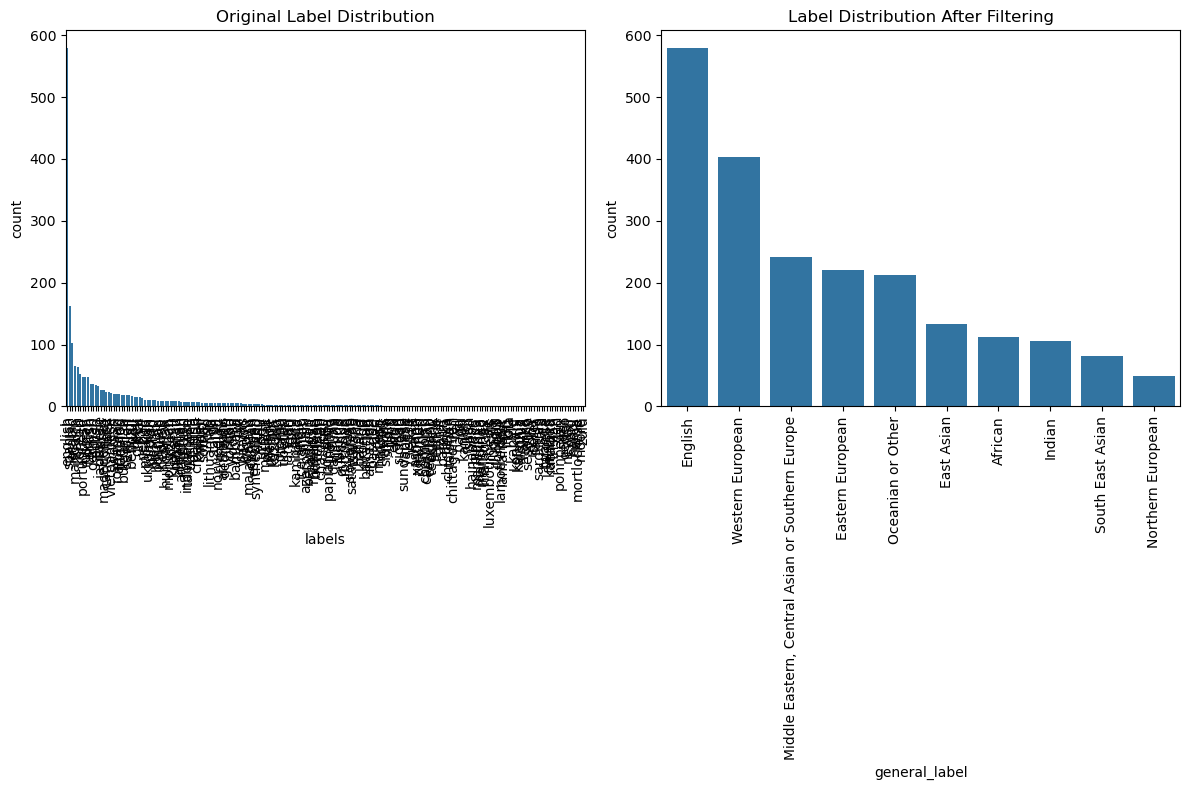

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 1-row, 2-column subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Visualize the original label distribution in the first subplot
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, ax=ax[0])
ax[0].set_title('Original Label Distribution')
ax[0].tick_params(axis='x', rotation=90)

# Visualize the label distribution after filtering in the second subplot
sns.countplot(data=df, x='general_label', order=df['general_label'].value_counts().index, ax=ax[1])
ax[1].set_title('Label Distribution After Filtering')
ax[1].tick_params(axis='x', rotation=90)

# Show the plots
plt.tight_layout()
plt.show()

In order to analyze the audio signals we need to convert the same into Mel-Frequency Cepstral Coefficients. Mel-Frequency Cepstral Coefficients (MFCCs) are a widely used and powerful feature extraction technique in audio signal processing, particularly in speech and music analysis. They are designed to represent the short-term power spectrum of a sound in a way that aligns with how the human auditory system perceives sound. The following steps are used to create a vector from the audio stream.

1. The audio signal is framed and windowed.
2. FFT is applied to each frame.
3. Mel filter banks are applied to the power spectrum.
4. Logarithmic compression is performed.
5. DCT is applied to obtain the static MFCCs.
6. Delta and delta-delta coefficients are computed to capture dynamic changes.
7. This results in a sequence of MFCC feature vectors for each speech utterance.

In [145]:
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

In [146]:
features = []
for file in tqdm(df['speech']):
    file_path = os.path.join(dir, file)
    mfcc = extract_mfcc(file_path)
    features.append(mfcc)

100%|██████████| 2138/2138 [02:57<00:00, 12.03it/s]


In [147]:
X = np.array(features)
y = df['general_label'].values


print("Shape of X:", X.shape) 
print("Shape of y:", y.shape)  

Shape of X: (2138, 13)
Shape of y: (2138,)


We will need to encode these categorical variables for the model to function properly and for oversampling

In [148]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [150]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y_encoded)

# Convert the resampled encoded labels back to the original labels
y_resampled_labels = label_encoder.inverse_transform(y_resampled)

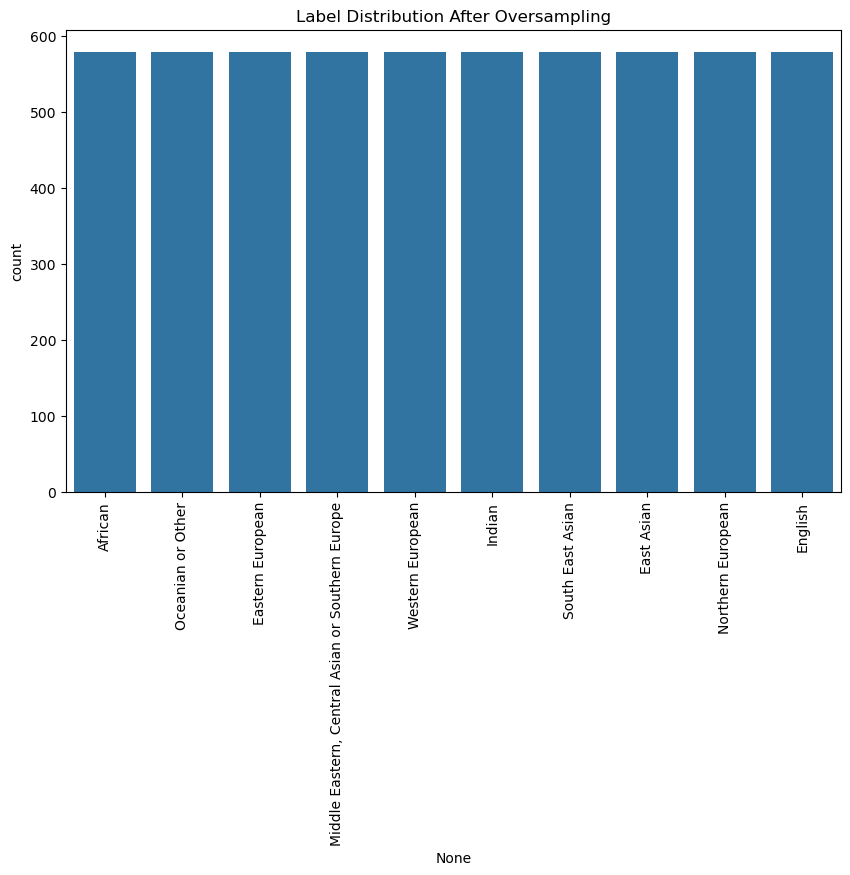

In [151]:
# Visualize the label distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(y_resampled_labels))
plt.title('Label Distribution After Oversampling')
plt.xticks(rotation=90)
plt.show()

As can be seen above, the distribution of the records have been balanced. Now we will split the data into train and test samples for the neural network

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Now we will build a model where use keras to create a convolutional neural network which will be utilized to classify the audio files

In [385]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

y_train_encoded = label_encoder.transform(y_train)  
y_test_encoded = label_encoder.transform(y_test)


y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)


model = Sequential()


model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

history = model.fit(X_train, y_train_encoded, epochs=150, batch_size=32, validation_data=(X_test, y_test_encoded))

E:\Users\91894\anaconda3\envs\python_ml_Data\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_71 (Conv1D)              │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,554 (392.79 KB)

 Trainable params: 100,170 (391.29 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1235 - loss: 2.3966 - val_accuracy: 0.1425 - val_loss: 2.2774
Epoch 2/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1728 - loss: 2.2368 - val_accuracy: 0.2029 - val_loss: 2.2094
Epoch 3/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1947 - loss: 2.2067 - val_accuracy: 0.1883 - val_loss: 2.1914
Epoch 4/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2238 - loss: 2.1414 - val_accuracy: 0.2245 - val_loss: 2.1417
Epoch 5/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2489 - loss: 2.0867 - val_accuracy: 0.2375 - val_loss: 2.0803
Epoch 6/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2597 - loss: 2.0419 - val_accuracy: 0.2599 - val_loss: 2.0667
Epoch 7/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2836 - loss: 1.9975 - val_accuracy: 0.2712 - val_loss: 2.0026
Epoch 8/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3232 - loss: 1.9229 - val_acc

Here a plot of the accuracy and loss of both the test data and train data is shown by which we can see that the model is converging

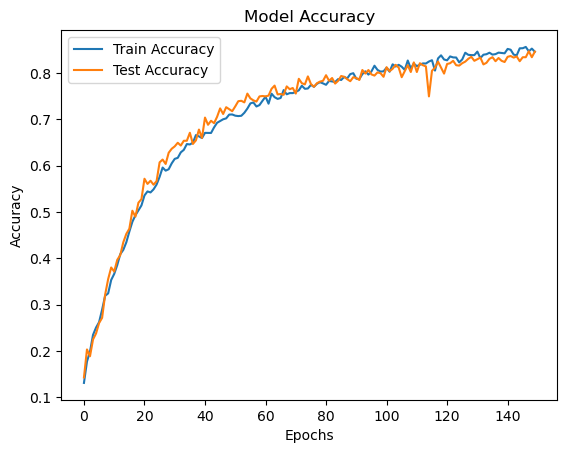

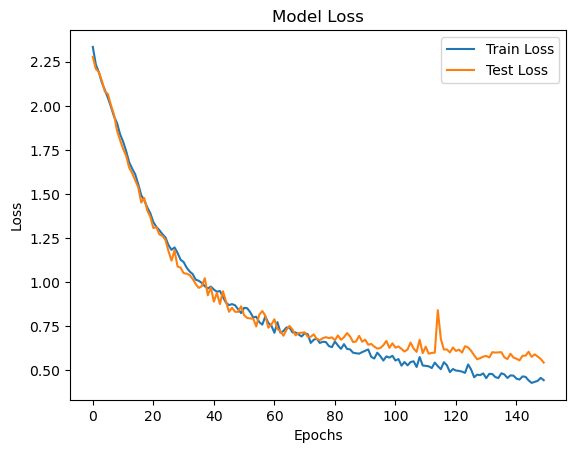

In [386]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We create a confusion matrix and see the accuracy score on the test data

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted Accuracy: 0.846286701208981


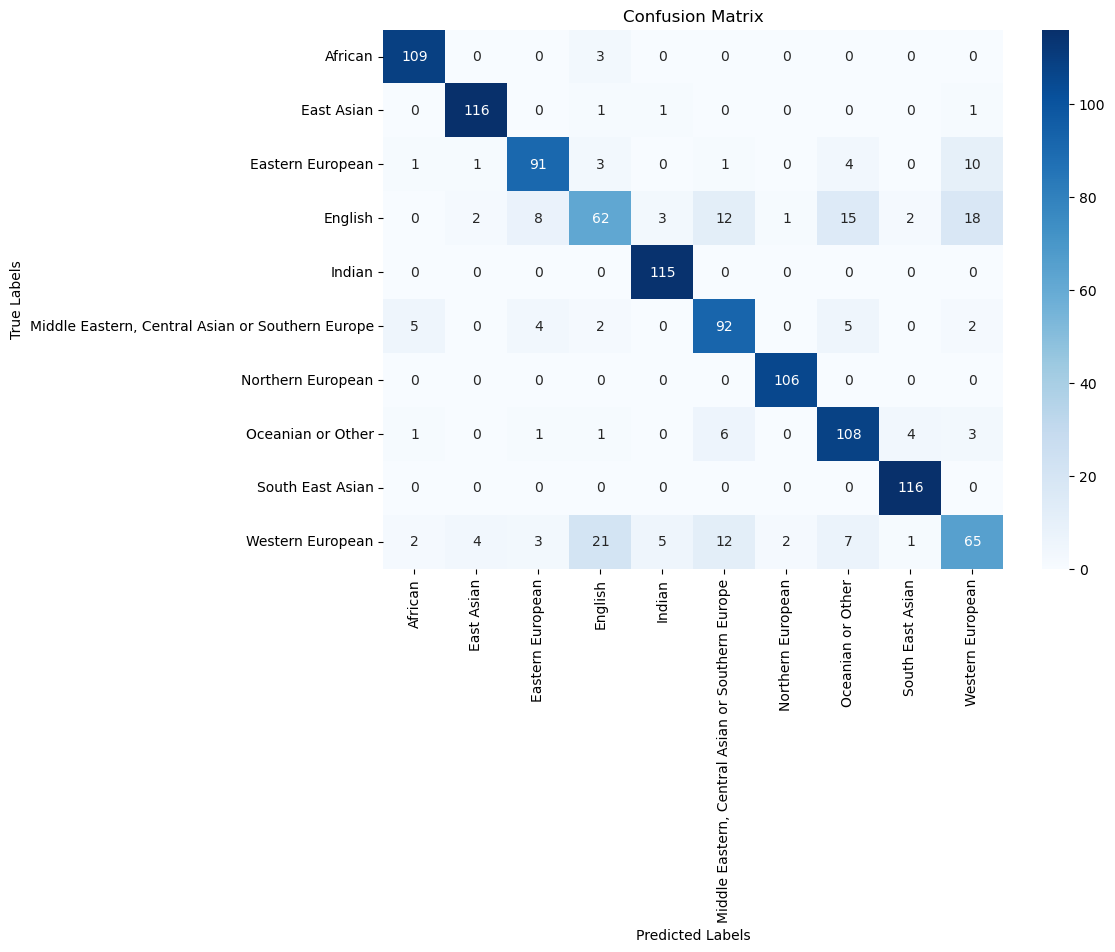

In [387]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_int = label_encoder.transform(y_test) 

accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")


cm = confusion_matrix(y_test_int, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Now we check the model for a random sample from the recording and see if the classification works in this scenario

In [388]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1) 
    return mfcc_mean

example_file =os.getcwd() + '/kaggle/input/recordings/recordings/arabic40.mp3'


mfcc_features = extract_mfcc(example_file)


mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted label for the audio file: Middle Eastern, Central Asian or Southern Europe


Checking if the model is able to classify an url link taken from avideo on wikipedia and also give out the probability of the prediction. For this we create a helper function to download the video and then ise moviepy to extract the audio from it

In [399]:
def download_video(url, save_path):
    headers = {
        "User-Agent": "Mozilla/5.0", 
        "Accept": "*/*",
        "Connection": "keep-alive"
    }
    response = requests.get(url, stream=True, headers=headers)
    response.raise_for_status()
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

video_url = 'https://upload.wikimedia.org/wikipedia/commons/transcoded/a/aa/BE_BEST-_A_SAFER_DIGITAL_FUTURE.webm/BE_BEST-_A_SAFER_DIGITAL_FUTURE.webm.720p.vp9.webm'
output_filename = 'video.mp4'
download_video(video_url,output_filename)


from moviepy import VideoFileClip
cvt_video = VideoFileClip("video.mp4")
ext_audio = cvt_video.audio

ext_audio.write_audiofile("audio.mp3")

MoviePy - Writing audio in audio.mp3


MoviePy - Done.


We will now check the predicted label of the video from the url link

In [403]:
mfcc_features = extract_mfcc("audio.mp3")


mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]} with a probability of : {max(predicted_prob[0])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted label for the audio file: Western European with a probability of : 0.4845055937767029


We will now save the model as well as the encoder for developing the streamlit app

In [401]:
import pickle
file = './NN_Accent_prediction.pkl'
with open(file, 'wb') as f:
    pickle.dump(model, f)

In [402]:
filename = 'label_encoder.pkl'
pickle.dump(label_encoder, open(filename, 'wb'))